##*1. Import semua Library yang diperlukan*

In [1]:
!pip install split-folders
import splitfolders 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from scipy.special import softmax
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##*2. Mount data dari Google Drive kemudian ekstrak* 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/Data/dataset_binatang.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset_binatang/cheetah/4_img_1553496707687.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496707754.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496707849.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496707901.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496707991.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708150.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708189.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708332.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708602.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708712.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708745.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708771.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708812.jpg  
  inflating: dataset_binatang/cheetah/4_img_1553496708911.jpg  
  inflating: dataset_binatang/cheetah/4_img_1

##*3. Split Folder menjadi Folder data training dan validasi*

In [4]:
splitfolders.ratio("dataset_binatang", output="dataset_binatang_split", seed=1337, ratio=(.8, .2), group_prefix=None) 

Copying files: 10400 files [00:04, 2087.15 files/s]


In [5]:
os.listdir('/content/dataset_binatang_split')

['val', 'train']

In [6]:
os.listdir('/content/dataset_binatang_split/train')

['panda', 'cat', 'cheetah', 'orang utan']

In [7]:
os.listdir('/content/dataset_binatang_split/val')

['panda', 'cat', 'cheetah', 'orang utan']

##*4. Menghitung jumlah gambar yang ada pada setiap subfolder train dan val*

In [8]:
print('total gambar KUCING di folder TRAIN :', len(os.listdir('/content/dataset_binatang_split/train/cat')))
print('total gambar CHEETAH di folder TRAIN :', len(os.listdir('/content/dataset_binatang_split/train/cheetah')))
print('total gambar ORANG UTAN di folder TRAIN :', len(os.listdir('/content/dataset_binatang_split/train/orang utan')))
print('total gambar PANDA di folder TRAIN :', len(os.listdir('/content/dataset_binatang_split/train/panda')))

total gambar KUCING di folder TRAIN : 2800
total gambar CHEETAH di folder TRAIN : 2800
total gambar ORANG UTAN di folder TRAIN : 1736
total gambar PANDA di folder TRAIN : 984


In [9]:
print('total gambar KUCING di folder VAL :', len(os.listdir('/content/dataset_binatang_split/val/cat')))
print('total gambar CHEETAH di folder VAL :', len(os.listdir('/content/dataset_binatang_split/val/cheetah')))
print('total gambar ORANG UTAN di folder VAL :', len(os.listdir('/content/dataset_binatang_split/val/orang utan')))
print('total gambar PANDA  di folder VAL :', len(os.listdir('/content/dataset_binatang_split/val/panda')))

total gambar KUCING di folder VAL : 700
total gambar CHEETAH di folder VAL : 700
total gambar ORANG UTAN di folder VAL : 434
total gambar PANDA  di folder VAL : 246


##*5. Preprocessing Data*

In [10]:
train_dir = "dataset_binatang_split/train"
val_dir = "dataset_binatang_split/val"

In [11]:
tinggi = 64
lebar = 64
batch_size = 16
class_mode = 'categorical'

# Augmentasi Data Gambar/Photo
train_datagenerator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

# Data augmentation pada data training saja sehingga dapat menjaga konsistensi terhadap data validation yang digunakan sebagai referensi
validation_datagenerator = ImageDataGenerator(
    rescale=1.0/255)

train_generator = train_datagenerator.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode=class_mode,
                                                    target_size=(tinggi, lebar),
                                                    shuffle=True)

validation_generator = validation_datagenerator.flow_from_directory(val_dir,
                                                            batch_size=batch_size,
                                                            class_mode=class_mode,
                                                            target_size=(tinggi, lebar),
                                                            shuffle=True)

Found 8320 images belonging to 4 classes.
Found 2080 images belonging to 4 classes.


##*6. Membuat Model*

In [12]:
# Model ini menggunakan layer Conv2d MaxPooling, Flatten, Dense, dan Dropout

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(4, activation='softmax')  
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 256)       1179904   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

##*7. Setting Optmizer*

In [13]:
int_lr = lr=0.0001
num_epochs = 150

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##*8. Callback*

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
      self.model.stop_training = True
      print("\nAkurasi dan Val Akurasi sudah melebihi 92% !\nHentikan Training!")
callbacks = myCallback()

##*9. Latih Model*

In [15]:
history = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              verbose=2,
              batch_size=32,
              callbacks=[callbacks])

Epoch 1/150
520/520 - 66s - loss: 1.1286 - accuracy: 0.4749 - val_loss: 0.9631 - val_accuracy: 0.5779 - 66s/epoch - 126ms/step
Epoch 2/150
520/520 - 57s - loss: 0.8606 - accuracy: 0.6516 - val_loss: 0.9433 - val_accuracy: 0.6313 - 57s/epoch - 110ms/step
Epoch 3/150
520/520 - 57s - loss: 0.7442 - accuracy: 0.7014 - val_loss: 0.6700 - val_accuracy: 0.7337 - 57s/epoch - 109ms/step
Epoch 4/150
520/520 - 56s - loss: 0.6952 - accuracy: 0.7245 - val_loss: 0.7988 - val_accuracy: 0.6957 - 56s/epoch - 108ms/step
Epoch 5/150
520/520 - 57s - loss: 0.6558 - accuracy: 0.7373 - val_loss: 0.7275 - val_accuracy: 0.7346 - 57s/epoch - 109ms/step
Epoch 6/150
520/520 - 57s - loss: 0.6301 - accuracy: 0.7450 - val_loss: 0.6613 - val_accuracy: 0.7337 - 57s/epoch - 109ms/step
Epoch 7/150
520/520 - 55s - loss: 0.5966 - accuracy: 0.7688 - val_loss: 0.6211 - val_accuracy: 0.7659 - 55s/epoch - 107ms/step
Epoch 8/150
520/520 - 56s - loss: 0.5790 - accuracy: 0.7712 - val_loss: 0.8476 - val_accuracy: 0.7034 - 56s/epo

## *10. Plot Akurasi dan Loss*

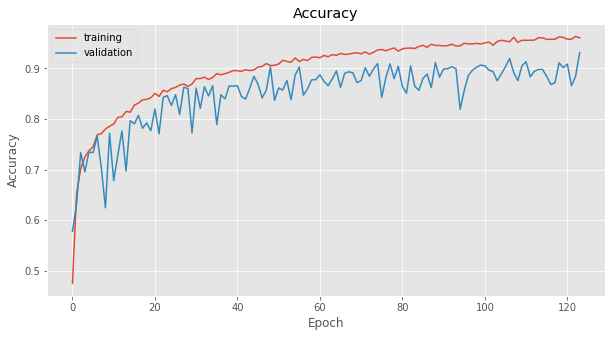

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

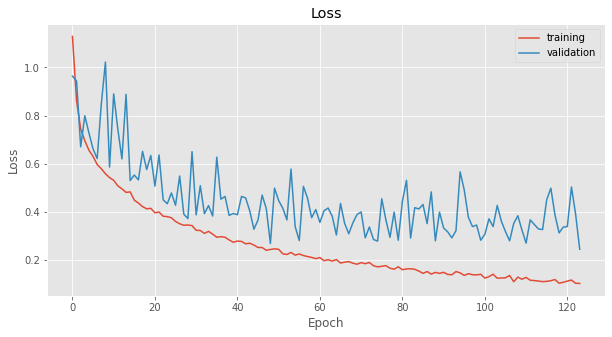

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## *11. Simpan ke dalam format SavedModel*

In [25]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

##*12. Convert SavedModel menjadi binatang.tflite*

In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('dataset_binatang.tflite')
tflite_model_file.write_bytes(tflite_model)

7048152

## SUBMISSION III PROYEK AKHIR MACHINE LEARNING INTERMEDIATE DICODING : IMG_CLASS TO TF_LITE : DONE. 

